In [109]:
import torch
import os
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    RandFlipd,
    Resized,
    NormalizeIntensityd,
    ResizeWithPadOrCropd,
    RandSpatialCropd
)
from monai.data import DataLoader, Dataset, ImageDataset
from monai.config import print_config
from monai.apps import download_and_extract
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from load_data import get_data
from transforms import transforms

In [110]:
set_determinism(seed=2023)
home = Path.home().as_posix()

In [111]:
datasets = {
    "ixi": {"path": home + r"/datasets/ixi/ixi_dataset.json", "label": "sex"},
    "ukb": {"path": home + r"/datasets/ukb/ukb_dataset.json", "label": "sex"},
}
    
data = get_data(
    "ixi",
    label=datasets["ixi"]["label"],
)

data["train"] = [{"image": os.path.join(home, i["image"]), "label": i["label"]} for i in data["train"]]
#print(data["train"])
#data_dicts = [{"image": files[i], "label": data["train"][1][i]} for i in range(len(files))]

pixdim = 1
img_size = (180//pixdim, 180//pixdim, 160//pixdim)

transform = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        #RandFlipd(keys=["image"], prob=1, spatial_axis=0),
        #Resized(keys=["image"], spatial_size=(40, 40, 40)),
        Spacingd(keys=['image'], pixdim=pixdim, mode=("bilinear")),
        ResizeWithPadOrCropd(keys=['image'], spatial_size=(img_size[0]+5, img_size[0]+5, img_size[0]+5), mode='constant', value=0.0),
        RandSpatialCropd(keys=['image'], roi_size=img_size, random_center=True, random_size=False),
        NormalizeIntensityd(keys=["image"]),
        #Orientationd(keys=["image", "label"], axcodes="PLS"),
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

#t = LoadImaged(keys=["image"])(data[0])
#print(t)

train_dataset = Dataset(
    data=data["train"],
    transform=transform,
)

train_loader = DataLoader(
    train_dataset,
)

data_first = first(train_loader)
print(f"image shape: {data_first['image'].shape}, label shape: {data_first['label'].shape}")

figsize=(100, 100)

/home/neutron/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([1, 1, 180, 180, 160]), label shape: torch.Size([1])


In [112]:
"""matshow3d(
    volume=data_first["image"],
    fig=None,
    title="input image",
    figsize=figsize,
    every_n=10,
    frame_dim=-1,
    show=True,
    cmap="gray",
)"""

'matshow3d(\n    volume=data_first["image"],\n    fig=None,\n    title="input image",\n    figsize=figsize,\n    every_n=10,\n    frame_dim=-1,\n    show=True,\n    cmap="gray",\n)'

In [33]:
"""matshow3d(
    volume=data_first["image"],
    fig=None,
    title="input image",
    figsize=figsize,
    every_n=10,
    frame_dim=-2,
    show=True,
    cmap="gray",
)"""

'matshow3d(\n    volume=data_first["image"],\n    fig=None,\n    title="input image",\n    figsize=figsize,\n    every_n=10,\n    frame_dim=-2,\n    show=True,\n    cmap="gray",\n)'

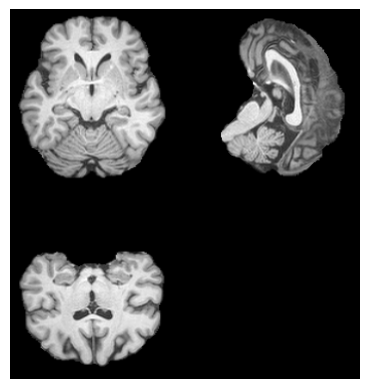

In [167]:
_, _, x, y, z = data_first["image"].shape
x_ = x//2
y_ = y//2
z_ = z//2
img1 = data_first["image"][0, 0, x_, :, :]
img2 = data_first["image"][0, 0, :, y_, :]
img3 = data_first["image"][0, 0, :, :, z_]
comb = torch.cat((img2, img3), 1)

black = torch.zeros(img1.shape[0], comb.shape[1] - img1.shape[1]) + -0.5587
comb2 = torch.cat((img1, black), 1)
combined = torch.cat((comb, comb2), 0)
fig = plt.figure()
plt.imshow(combined, cmap="gray")
plt.axis("off")  # Turn off axis labels
#plt.suptitle("Brain MRI overview", y=0.745)
# plt.title(f"slice {i}")
plt.savefig(r"/home/neutron/dev/thesis/src/ixi_image.png", bbox_inches='tight', pad_inches=0.0)
plt.show()